# Correct inconsistent default value

Determines a new default value for the input variable `QE01:b1_gradient` (PV name: `QUAD:IN20:425:BACT`), which was inconsistent with is specified range in the original definition of the model.

In [1]:
import torch
import matplotlib.pyplot as plt

from lume_model.utils import variables_from_yaml
from lume_model.torch import LUMEModule, PyTorchModel

## Create model

In [2]:
# load transformers
input_sim_to_nn = torch.load("model/input_sim_to_nn.pt")
output_sim_to_nn = torch.load("model/output_sim_to_nn.pt")

In [3]:
# load in- and output variable specification
sim_input_variables, sim_output_variables = variables_from_yaml(open("model/sim_variables.yml"))

In [4]:
# create LUME-model
lume_model = PyTorchModel(
    model_file="model/model.pt",
    input_variables=sim_input_variables,
    output_variables=sim_output_variables,
    input_transformers=[input_sim_to_nn],
    output_transformers=[output_sim_to_nn],
)

In [5]:
# wrap in LUMEModule
lume_module = LUMEModule(
    model=lume_model,
    feature_order=lume_model.features,
    output_order=lume_model.outputs,
)
lume_module

LUMEModule(
  (base_model): Sequential(
    (0): Linear(in_features=16, out_features=100, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=100, out_features=200, bias=True)
    (3): ELU(alpha=1.0)
    (4): Dropout(p=0.05, inplace=False)
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): ELU(alpha=1.0)
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=200, out_features=300, bias=True)
    (9): ELU(alpha=1.0)
    (10): Dropout(p=0.05, inplace=False)
    (11): Linear(in_features=300, out_features=300, bias=True)
    (12): ELU(alpha=1.0)
    (13): Dropout(p=0.05, inplace=False)
    (14): Linear(in_features=300, out_features=200, bias=True)
    (15): ELU(alpha=1.0)
    (16): Dropout(p=0.05, inplace=False)
    (17): Linear(in_features=200, out_features=100, bias=True)
    (18): ELU(alpha=1.0)
    (19): Dropout(p=0.05, inplace=False)
    (20): Linear(in_features=100, out_features=100, bias=True)
    (21): ELU(alpha=1.0)
    (22): Linear(in_f

## Compute 1d scan of transverse beam size

In [6]:
# variable which needs default correction
var_name = "QE01:b1_gradient"
var_idx = list(sim_input_variables.keys()).index(var_name)

# old default values
x_default_old = torch.tensor([sim_input_variables[key].default for key in sim_input_variables.keys()], dtype=torch.double)

In [7]:
# define objective model
class ObjectiveModel(torch.nn.Module):
    def __init__(self, model: LUMEModule):
        super(ObjectiveModel, self).__init__()
        self.model = model

    @staticmethod
    def function(sigma_x: torch.Tensor, sigma_y: torch.Tensor) -> torch.Tensor:
        # using this calculation due to occasional negative values
        return torch.sqrt(sigma_x ** 2 + sigma_y ** 2) * 1e3

    def forward(self, x) -> torch.Tensor:
        idx_sigma_x = self.model.output_order.index("sigma_x")
        idx_sigma_y = self.model.output_order.index("sigma_y")
        sigma_x = self.model(x)[..., idx_sigma_x]
        sigma_y = self.model(x)[..., idx_sigma_y]
        return self.function(sigma_x, sigma_y)


objective_model = ObjectiveModel(lume_module)

In [8]:
# define 1D scan sample function
def scan_x(x_default, name, v_lim, n_samples=1000):
    idx = list(sim_input_variables.keys()).index(name)
    samples = x_default.repeat(n_samples, 1)
    samples[:, idx] = torch.linspace(v_lim[0], v_lim[1], n_samples, dtype=x_default.dtype)
    return samples

In [9]:
# 1d scan over original range
v_lim_old = sim_input_variables[var_name].value_range
x_scan_old = scan_x(x_default_old, var_name, v_lim_old)
with torch.no_grad():
    y_scan_old = objective_model(x_scan_old)

# 1D scan over extended range
v_max = max(sim_input_variables[var_name].value_range)
x_scan = scan_x(x_default_old, var_name, [-v_max, v_max])
with torch.no_grad():
    y_scan = objective_model(x_scan)

In [10]:
# new default
idx_min = torch.argmin(x_scan_old[:, var_idx])
x_default_new = x_scan_old[idx_min, :]
y_default_new = y_scan_old[idx_min]
x_default_new[var_idx].item()

1.0007061999094193

In [11]:
# load example data
inputs_small = torch.load("info/inputs_small.pt")
outputs_small = torch.load("info/outputs_small.pt")

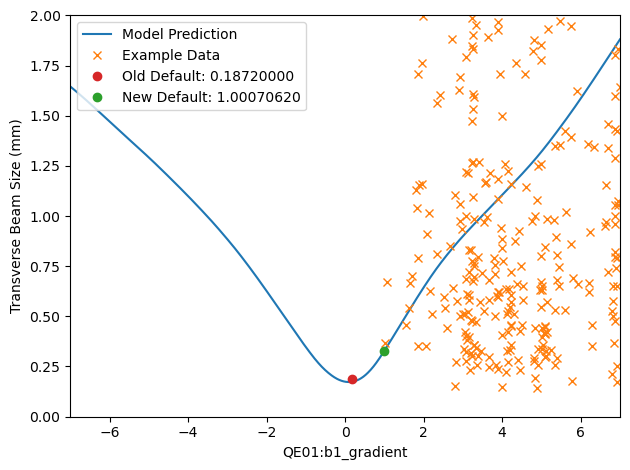

In [12]:
# plot scan and example data
"""
The example data does not match model predictions here since they are distributed across the entire domain
rather than be restricted to the default values for each input besides QE01:b1_gradient.
"""
fig, ax = plt.subplots()
ax.plot(x_scan[:, var_idx], y_scan, "C0-", label="Model Prediction")
ax.plot(inputs_small[:, var_idx], objective_model.function(outputs_small[:, 0], outputs_small[:, 1]),
        "C1x", label="Example Data")
ax.plot(x_default_old[var_idx], sim_input_variables[var_name].default, "C3o",
        label="Old Default: {:.8f}".format(x_default_old[var_idx]))
ax.plot(x_default_new[var_idx], y_default_new, "C2o",
        label="New Default: {:.8f}".format(x_default_new[var_idx]))
ax.set_xlabel(var_name)
ax.set_ylabel("Transverse Beam Size (mm)")
ax.set_xlim(torch.min(x_scan[:, var_idx]), torch.max(x_scan[:, var_idx]))
ax.set_ylim(0.0, 2.0)
ax.legend(loc="upper left")
fig.tight_layout()

## Verify model scans at new default

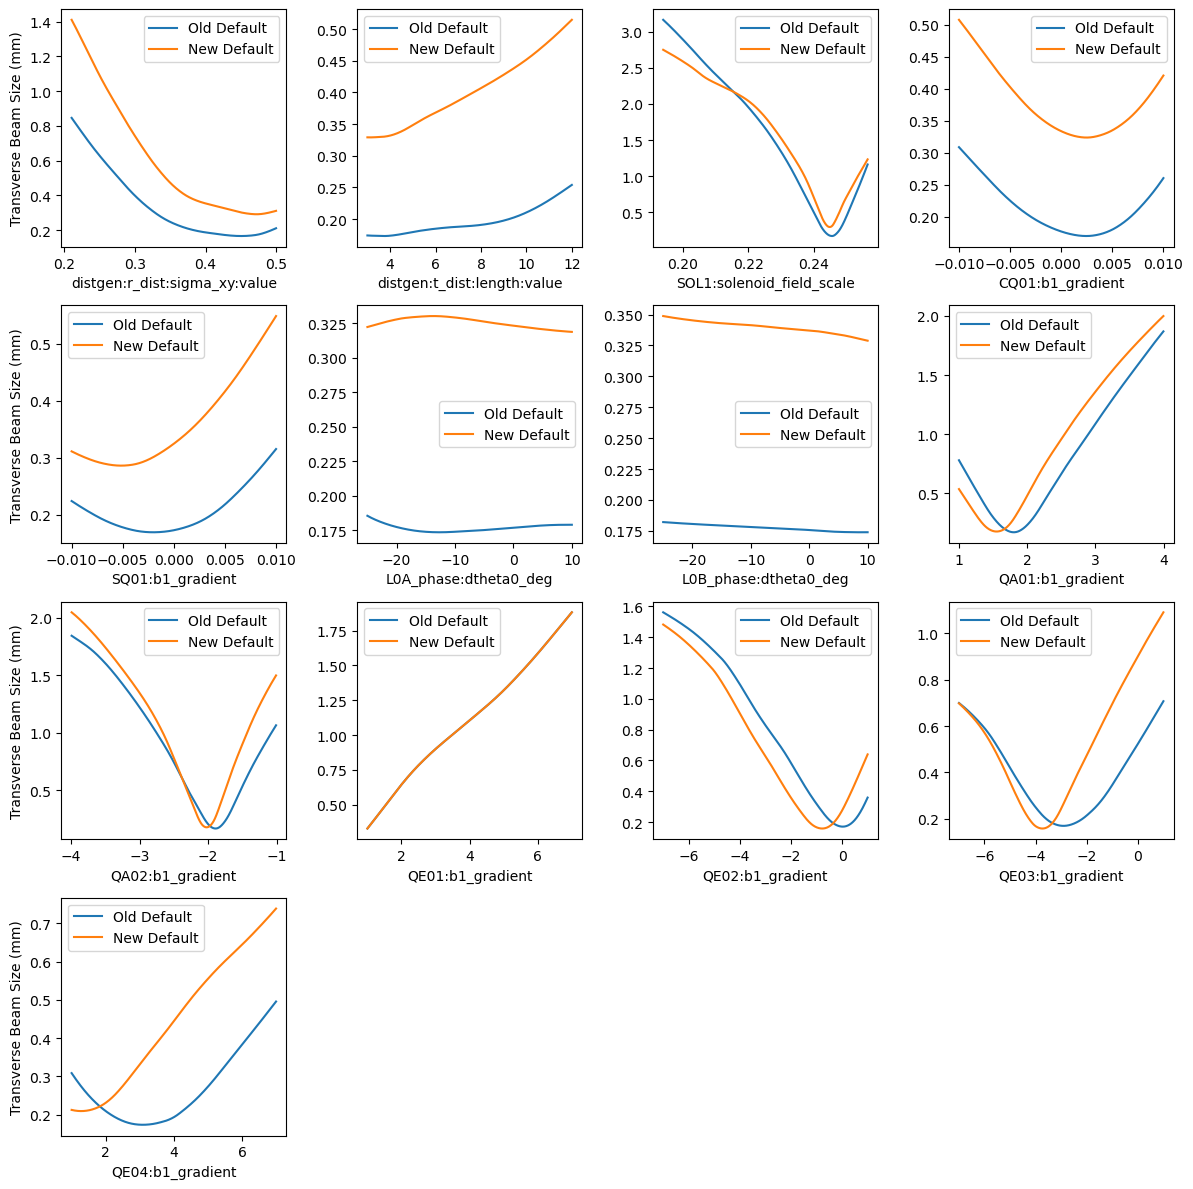

In [13]:
# compare 1D scans for old and new default
nrows, ncols = 4, 4
figsize = (12, 12 * nrows / ncols)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharey=False, figsize=figsize)
n_skip = 0
for i in range(nrows * ncols):
    ax_i = ax[i // ncols, i % ncols]
    if i + n_skip >= len(sim_input_variables.keys()):
        ax_i.axis('off')
    else:
        name = list(sim_input_variables.keys())[i + n_skip]
        v_lim = sim_input_variables[name].value_range

        while not v_lim[0] < v_lim[1]:
            n_skip += 1
            name = list(sim_input_variables.keys())[i + n_skip]
            v_lim = sim_input_variables[name].value_range

        # compute 1D scans
        x_scan_old = scan_x(x_default_old, name, v_lim)
        y_scan_old = objective_model(x_scan_old).detach()
        x_scan_new = scan_x(x_default_new, name, v_lim)
        y_scan_new = objective_model(x_scan_new).detach()

        # plot data
        idx = list(sim_input_variables.keys()).index(name)
        ax_i.plot(x_scan_old[:, idx], y_scan_old, "C0", label="Old Default")
        ax_i.plot(x_scan_new[:, idx], y_scan_new, "C1", label="New Default")
        ax_i.set_xlabel(name)
        ax_i.legend()
        if i % ncols == 0:
            ax_i.set_ylabel("Transverse Beam Size (mm)")
fig.tight_layout()

## Transform to PV Variables

In [14]:
# load pv_to_sim transformers
input_pv_to_sim = torch.load('model/input_pv_to_sim.pt')
output_pv_to_sim = torch.load('model/output_pv_to_sim.pt')

In [15]:
# load in- and output variable specification
pv_input_variables, pv_output_variables = variables_from_yaml(open("model/pv_variables.yml"))

In [16]:
# verify old default is matching
x_default_pv = torch.tensor([pv_input_variables[key].default for key in pv_input_variables.keys()], dtype=torch.double)
torch.allclose(x_default_pv, input_pv_to_sim.untransform(x_default_old.to(torch.double)))

True

In [17]:
# new default
x_default_pv_new = input_pv_to_sim.untransform(x_default_new)
x_default_pv_new[var_idx].item()

-1.0807627139393465

In [18]:
# verify new default is in range
v_range = pv_input_variables[list(pv_input_variables.keys())[var_idx]].value_range
(v_range[0] <= x_default_pv_new[idx] <= v_range[1]).item()

True